# Metric 2: Interaction-to-Booking Ratio

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from file_utils import read_from_pickle

In [3]:
df_contacts = read_from_pickle('./data/df_contacts.pkl')
df_contacts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27886 entries, 0 to 27886
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id_guest_anon                         27886 non-null  object        
 1   id_host_anon                          27886 non-null  object        
 2   id_listing_anon                       27886 non-null  object        
 3   ts_interaction_first                  27886 non-null  datetime64[ns]
 4   ts_reply_at_first                     25854 non-null  datetime64[ns]
 5   ts_accepted_at_first                  16415 non-null  datetime64[ns]
 6   ts_booking_at                         11587 non-null  datetime64[ns]
 7   ds_checkin_first                      27886 non-null  datetime64[ns]
 8   ds_checkout_first                     27886 non-null  datetime64[ns]
 9   m_guests                              27886 non-null  float64       
 10  m_i

## Explorative Data Analysis (EDA)

In [4]:
df_contacts['ts_booking_at'].isnull().value_counts()

ts_booking_at
True     16299
False    11587
Name: count, dtype: int64

In [5]:
df_bookings = df_contacts[df_contacts['ts_booking_at'].notnull()].copy()
df_bookings.shape

(11587, 14)

In [6]:
df_monthly_contacts = pd.DataFrame(data={
    'period': df_contacts['ts_interaction_first'].dt.to_period(freq='M').astype(str),
    'interactions': df_contacts['m_interactions'],
    'bookings': df_contacts['ts_booking_at'].map(lambda x: 1 if x is not pd.NaT else 0)
}).groupby(by=['period'], group_keys=True).sum()
df_monthly_contacts

,interactions,bookings
period,,
2016-01,54125,2139
2016-02,34092,1796
2016-03,32802,1760
2016-04,32301,1674
2016-05,37424,2047
2016-06,39483,2171


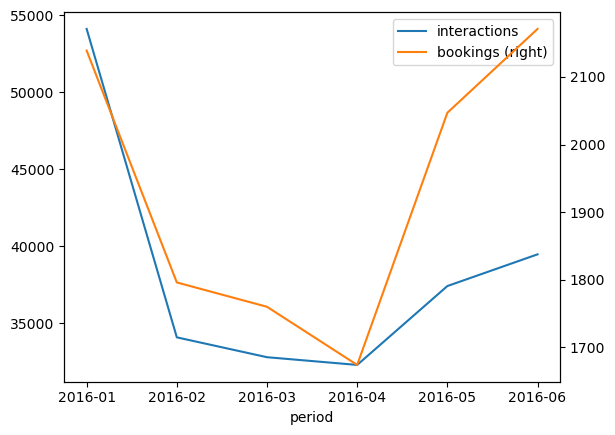

In [7]:
df_monthly_contacts.plot(y=['interactions', 'bookings'], secondary_y='bookings', kind='line')
plt.show()

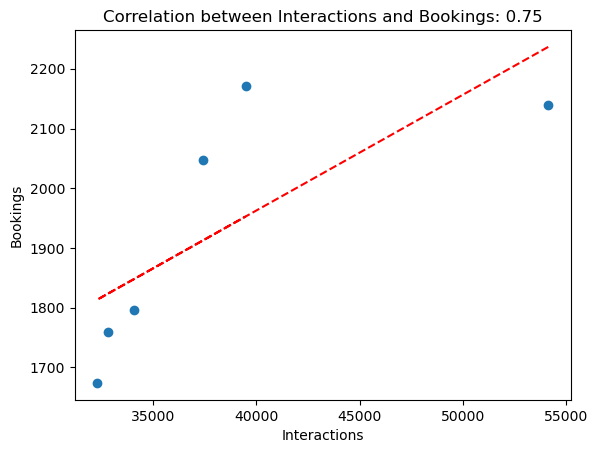

In [8]:
plt.scatter(df_monthly_contacts['interactions'], df_monthly_contacts['bookings'])
z = np.polyfit(df_monthly_contacts['interactions'], df_monthly_contacts['bookings'], 1)
p = np.poly1d(z)
plt.plot(df_monthly_contacts['interactions'],p(df_monthly_contacts['interactions']),"r--")
plt.xlabel('Interactions')
plt.ylabel('Bookings')

# calculate correlation coefficient
cc = np.corrcoef(df_monthly_contacts['interactions'], df_monthly_contacts['bookings'])[0, 1]

plt.title('Correlation between Interactions and Bookings: %.2f' % cc)
plt.show()

### Checking for outliers

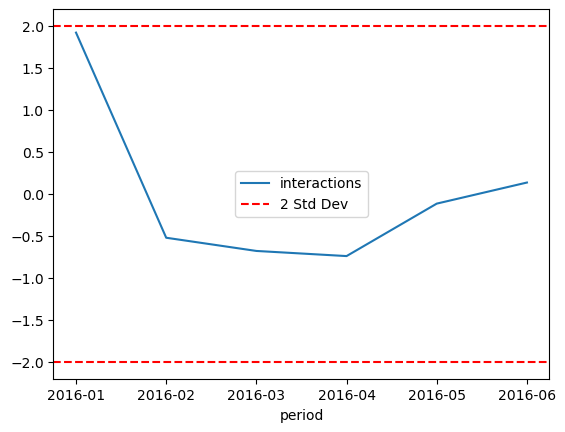

In [9]:
def zscores(series, x=2):
    mean = series.mean()
    std_dev = series.std()
    threshold = x * std_dev
    zscore_series = (series - mean) / std_dev
    return {
        'zscores': zscore_series,
        'threshold': threshold,
        'mean': mean,
        'std_dev': std_dev,
        'max_threshold': mean + threshold,
        'min_threshold': mean - threshold
    }
    
# plot with threshold lines and zscore
x = 2
zscore = zscores(df_monthly_contacts['interactions'], x)
zscore['zscores'].plot()
plt.axhline(x, color='r', linestyle='--', label=f'{x} Std Dev')
plt.axhline(-x, color='r', linestyle='--')
plt.legend()
plt.show()


In [13]:
df_monthly_contacts

,interactions,bookings,interaction_to_booking_ratio
period,,,
2016-01,54125,2139,0.039520
2016-02,34092,1796,0.052681
2016-03,32802,1760,0.053655
2016-04,32301,1674,0.051825
2016-05,37424,2047,0.054698
2016-06,39483,2171,0.054986


## Metric calculation

In [18]:
df_monthly_contacts['interaction_to_booking_ratio'] = df_monthly_contacts['bookings'] / df_monthly_contacts['interactions'] * 100
df_monthly_contacts

,interactions,bookings,interaction_to_booking_ratio
period,,,
2016-01,54125,2139,3.951963
2016-02,34092,1796,5.268098
2016-03,32802,1760,5.365526
2016-04,32301,1674,5.182502
2016-05,37424,2047,5.469752
2016-06,39483,2171,5.498569


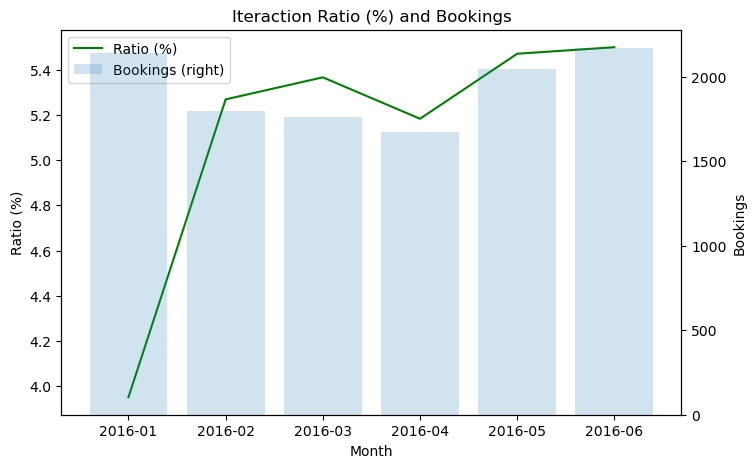

In [19]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax1.plot(df_monthly_contacts['interaction_to_booking_ratio'], color='g')
ax2.bar(df_monthly_contacts.index, df_monthly_contacts['bookings'], alpha=0.2)

## add legends
lns1 = ax1.get_lines()
lns2 = ax2.get_children()[1:3]
ax1.legend(lns1 + lns2, ['Ratio (%)', 'Bookings (right)'], loc=0)

## add labels
ax1.set_title('Iteraction Ratio (%) and Bookings')
ax1.set_xlabel('Month')
ax1.set_ylabel('Ratio (%)')
ax2.set_ylabel('Bookings')

plt.show()

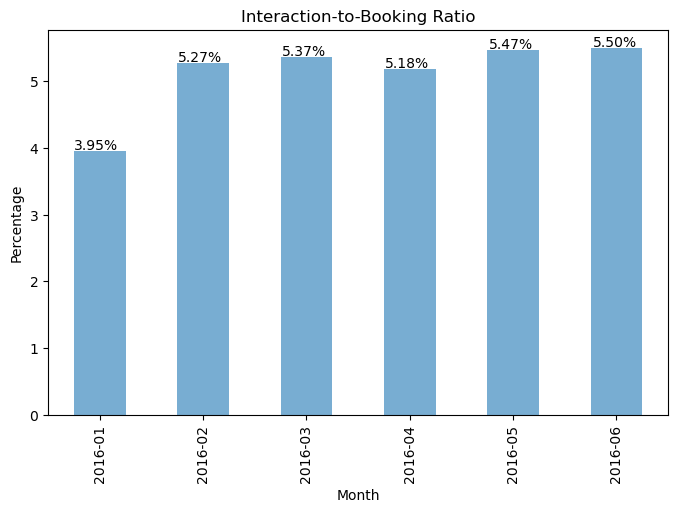

In [21]:


ax = df_monthly_contacts.plot(y=['interaction_to_booking_ratio'], kind='bar', figsize=(8, 5), alpha=0.6)
# add data labels as percentages
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() * 1.005, p.get_height() * 1.005))

ax.legend().remove()
ax.set_title('Interaction-to-Booking Ratio')
ax.set_xlabel('Month')
ax.set_ylabel('Percentage')

# save plot to file
plt.savefig('./plots/interaction-to-booking-ratio.png', bbox_inches='tight')

plt.show()